In [10]:

import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils import data
def prepare_data():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)

    root_dir = "./data3/train";
    train_set = datasets.ImageFolder(root = root_dir,
                transform = transforms.ToTensor())

    trainloader = data.DataLoader(train_set, batch_size = 4, shuffle = True)

    root_dir = "./data3/test";

    train_set = datasets.ImageFolder(root = root_dir,
                transform = transforms.ToTensor())

    testloader = data.DataLoader(train_set, batch_size =4, shuffle = True)
    classes = ('Natalie Portman', 'Julia Roberts', 'Neil Patrick Harris'
                    , 'Keifer Sutherland', 'Ben Stiller', 'Anne Hathaway'
                    , 'David Boreanaz', 'Jamie Foxx', 'Sofia Vergara'
                    , 'Elizabeth Banks', 'Jensen Ackles', 'Amy Adams'
                    , 'Kristen Bell', 'Bradley Cooper', 'Emily Deschanel'
                    , 'Zooey Deschanel', 'Jon Hamm', 'Scarlett Johansson'
                    , 'Blake Lively', 'Eva Longoria', 'Amy Poehler'
                    , 'Kristen Stewart', 'Kerry Washington', 'Leighton Meester'
                    , 'Olivia Wilde', 'Zac Efron', 'Miley Cyrus','Jim Parsons')
    return trainloader, testloader, classes
trainloader, testloader, classes = prepare_data()
#
print("train size: " + str(len(trainloader)))
#
print("test size: " + str(len(testloader)))

train size: 2800
test size: 693


cpu
Leighton Meester


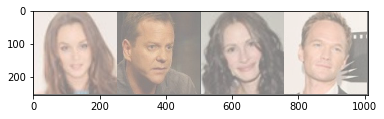

In [11]:
trainloader, testloader, classes = prepare_data()

import matplotlib.pyplot as plt
import numpy as np


# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.device)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(1)))

In [13]:
import math
import torch.nn as nn
import torch.nn.functional as F

def mini_batch_normalization(mini_batch, epsilon):
    # print("before mean: ", mini_batch.mean())
    batch_size = mini_batch.shape[0]
    # print(mini_batch.shape)
    # print(batch_size)
    number_of_layers = mini_batch.shape[1]
    sum = torch.zeros(mini_batch.shape[2], mini_batch.shape[3])
    for i in range(number_of_layers):
        # print(i)
        for j in range(batch_size):
            # print("mini batch mean: ", mini_batch[j][i].mean())
            sum = sum + mini_batch[j][i]
            # print("sum mean: ", sum.mean())
        # print(sum.mean())
        mean = sum / batch_size
        sum = 0
        # print("Mean: ",mean.mean())
        for j in range(batch_size):
            sum += (mini_batch[j][i] - mean)**2
        variance = sum / batch_size
        # print(mean, variance)
        for j in range(batch_size):
            mini_batch[j][i] = (mini_batch[j][i] - mean)  / torch.sqrt(variance + epsilon)
            # print("after mean: ", mini_batch[j][i].mean())
        sum = 0
    return mini_batch

def prepare_and_init_Net(number_layers_1, number_layers_2, number_layers_3, eps):
    class Net(nn.Module):
        def __init__(self, device):
            super(Net, self).__init__()
            self.conv1 = nn.Conv2d(3, 6, 11)
            self.conv2 = nn.Conv2d(6, 12, 9)
            self.conv3 = nn.Conv2d(12, 24, 7)
            self.conv4 = nn.Conv2d(24, 30, 6)
            self.pool2 = nn.MaxPool2d(2, 2)
            # self.conv2_bn = mini_batch_normalization()
            # self.conv2_bn_24 = nn.BatchNorm2d(24)
            # self.conv2_bn_12 = nn.BatchNorm2d(12)
            # self.conv2_bn_6 = nn.BatchNorm2d(6)
            # self.pool3 = nn.MaxPool2d(3,3)
            self.fc1 = nn.Linear(30 * 10 * 10, 600)       #coś tu się dzieje, nie jestem pewnien co
            self.fc1_bn = nn.BatchNorm1d(600)
            self.fc3 = nn.Linear(600, 28)

        def forward(self, x):
            # print(x.shape)
            # print((mini_batch_normalization(self.conv1(x), eps)).shape)
            x = self.pool2(F.relu(mini_batch_normalization(self.conv1(x), eps)))
            # print(x.shape)
            x = self.pool2(F.relu(mini_batch_normalization(self.conv2(x), eps)))
            # print(x.shape)
            x = self.pool2(F.relu(mini_batch_normalization(self.conv3(x), eps)))
            # print(x.shape)
            x = self.pool2(F.relu(mini_batch_normalization(self.conv4(x), eps)))
            # print(x.shape)
            x = x.view(-1, 30 * 10 * 10)
            x = F.relu(self.fc1_bn(self.fc1(x)))
            # x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return x


    net = Net(device='cuda:0')
    return net
# print(net.parameters())

In [14]:
import torch.optim as optim

net = prepare_and_init_Net(6, 12, 24, 10**(-15))

def crit_and_opt(learning_rate):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    return criterion, optimizer

In [15]:
def cuda_init():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    return device
# Assuming that we are on a CUDA machine, this should print a CUDA device:


In [16]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)
def accuracy(device, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print('Accuracy of the network on the 2772 test images: %f %%' % (
        100 * correct / total))
        return 100 * correct / total


In [17]:
def learn(device, trainloader, testloader, optimizer, criterion):
    running_loss_for_optimizer = 0.0
    running_loss = 0.0
    loss_for_optimizer = 1.0
    learning_rate = 0.001
    counter=0
    for epoch in range(15):  # loop over the dataset multiple times


        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            # inputs, labels = data
            inputs, labels = data[0].to(device), data[1].to(device)
            # print(inputs.shape)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            # print(outputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            running_loss_for_optimizer += loss.item()
            if i % 100 == 99:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0
        print("running loss at end of epoch: ", running_loss_for_optimizer/len(trainloader))
        if(accuracy(device, testloader) > 75):
            break
        # accuracy(device, testloader)
        if(running_loss_for_optimizer/len(trainloader) < loss_for_optimizer):
            learning_rate /= 2
            loss_for_optimizer /= 2
            criterion, optimizer = crit_and_opt(learning_rate)
            print( "devaluating optimizer, current value: ", loss_for_optimizer)
        running_loss_for_optimizer = 0.0
        running_loss = 0.0


    print('Finished Training')



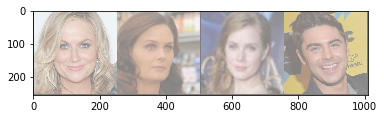

GroundTruth:  Amy Poehler Emily Deschanel Amy Adams Zac Efron


In [18]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
trainloader, testloader, classes = prepare_data()
device = cuda_init()
net = prepare_and_init_Net(6, 12, 24, 10**(-15))
criterion, optimizer = crit_and_opt(0.001)
learn(device, trainloader, testloader, optimizer, criterion)

[1,   100] loss: 3.366
[1,   200] loss: 3.299
[1,   300] loss: 3.194
[1,   400] loss: 3.107
[1,   500] loss: 3.116
[1,   600] loss: 3.028
[1,   700] loss: 3.020
[1,   800] loss: 3.046
[1,   900] loss: 2.949
[1,  1000] loss: 2.914
[1,  1100] loss: 2.867


In [ ]:
torch.set_default_tensor_type(torch.FloatTensor)
import math
device = torch.device("cpu")
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.device)
print(images[0].shape)
print(torch.ones(images.shape[2], 1).shape)

In [ ]:
print(images[3][0])

In [ ]:
def tensor_2d_mean(image):
    return torch.mm(torch.mm(image,torch.ones(image.shape[0], 1)).T, torch.ones(image.shape[1], 1)) / (image.shape[0]*image.shape[1])



print(tensor_2d_mean(images[3][0]))

print(images[0][0].mean())

In [ ]:
torch.set_default_tensor_type(torch.FloatTensor)
import math
device = torch.device("cpu")
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.device)
print(images[0].shape)
print(torch.ones(images.shape[2], 1).shape)
# print(images.reshape(images.shape[1], images.shape[0], images.shape[2], images.shape[3]))
def mini_batch_normalization(mini_batch, epsilon):
    print("before mean: ", mini_batch.mean())
    batch_size = mini_batch.shape[0]
    print(mini_batch.shape)
    print(batch_size)
    number_of_layers = mini_batch.shape[1]
    sum = torch.zeros(mini_batch.shape[2], mini_batch.shape[3])
    for i in range(number_of_layers):
        print(i)
        for j in range(batch_size):
            print("mini batch mean: ", mini_batch[j][i].mean())
            sum = sum + mini_batch[j][i]
            print("sum mean: ", sum.mean())
        print(sum.mean())
        mean = sum / batch_size
        sum = 0
        print("Mean: ",mean.mean())
        for j in range(batch_size):
            sum += (mini_batch[j][i] - mean)**2
        variance = sum / batch_size
        # print(mean, variance)
        for j in range(batch_size):
            mini_batch[j][i] = (mini_batch[j][i] - mean)  / torch.sqrt(variance + epsilon)
            print("after mean: ", mini_batch[j][i].mean())
        sum = 0
    return mini_batch
#


# print(images.mean())
print(mini_batch_normalization(images, 10**(-20)).mean())